[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


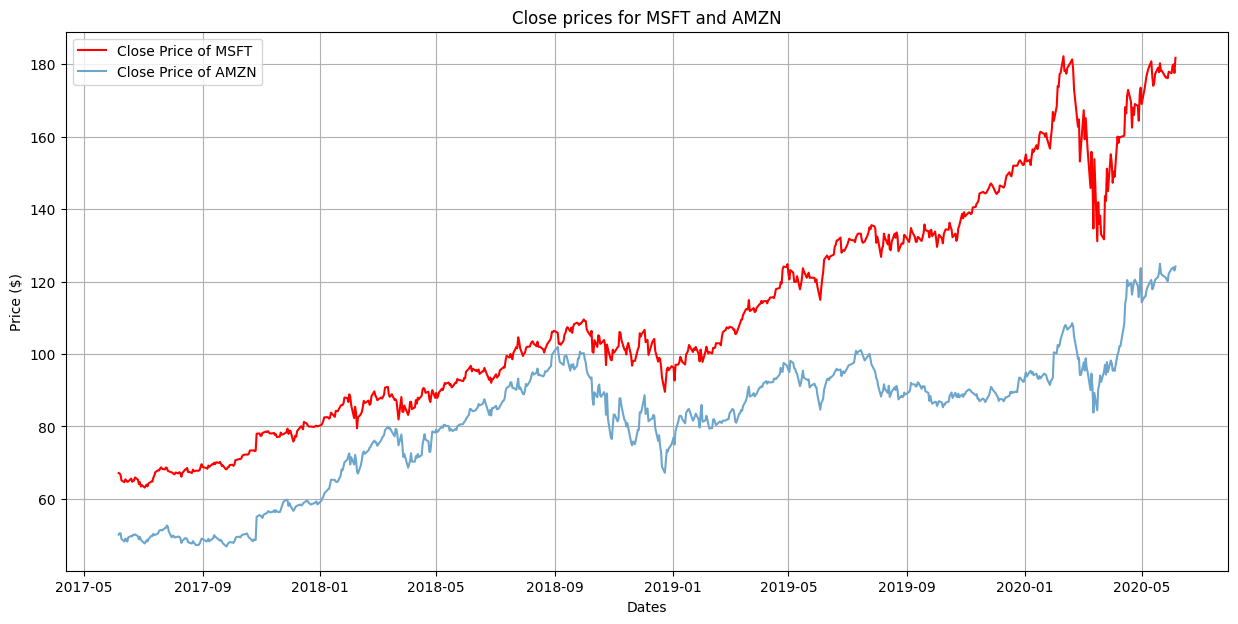

Hedge Ratio =  1.3535035899476429
Correlation =  0.8691773493531993


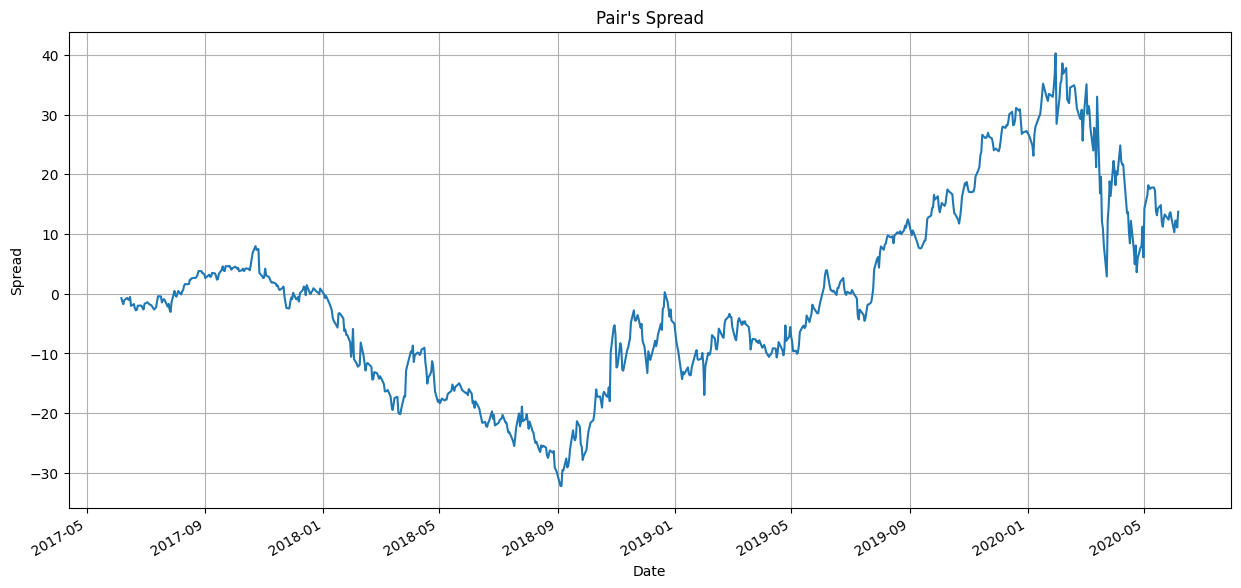

In [ ]:
# Import the libraries
import pandas as pd
import yfinance as yf
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Define list of tickers
tickers_list = ["MSFT", "AMZN"]

# Define data with Dataframe
data = pd.DataFrame(columns=tickers_list)

# Fetch the data
for ticker in tickers_list:
    data[ticker] = yf.download(ticker,'2017-06-06','2020-06-06')['Adj Close']

# Show first five rows of the data
data.head()

%matplotlib inline

# Customise the size of the plot
plt.figure(figsize=(15, 7))
plt.plot(data['MSFT'], lw=1.5, label='Close Price of MSFT',color='red')
plt.plot(data['AMZN'], lw=1.5, label='Close Price of AMZN',color='#6CA6CD')
plt.grid(True)
plt.legend(loc=0)

# This helps us tighten the figure margins
plt.axis('tight')
plt.xlabel('Dates')
plt.ylabel('Price ($)')
plt.title('Close prices for MSFT and AMZN')
plt.grid(True);
plt.show()
                # Import the packages
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

# Train-test-split
train_close, test_close = train_test_split(data[ticker], test_size=0.5, shuffle=False)

# Create a train dataframe of 2 assets
train = pd.DataFrame()
train['MSFT'] = data['MSFT']
train['AMZN'] = data['AMZN']

# Run OLS regression
model= sm.OLS(train["MSFT"],train["AMZN"]).fit()

# Print regression summary results
print('Hedge Ratio = ', model.params[0])
# Calculate spread
spread = train["MSFT"] - model.params[0] * train["AMZN"]
# Plot the spread
plot = spread.plot(figsize=(15, 7), title = "Pair's Spread")
plot.set_ylabel("Spread")
plot.grid(True);

# Calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)
test= pd.DataFrame()
test['MSFT'] = data['MSFT']
test['AMZN'] = data['AMZN']
# Calculate correlation
corr = train["MSFT"].corr(train["AMZN"])
print('Correlation = ', corr)

[*********************100%%**********************]  2 of 2 completed


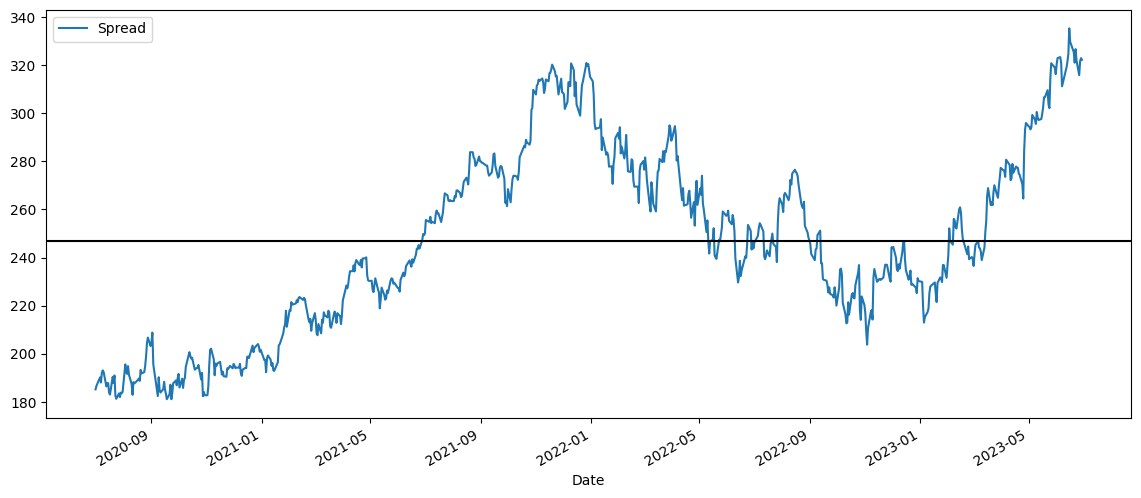

In [45]:
stock_pair = [ 'AMZN','MSFT']
asset_pairs =  yf.download(stock_pair, start="2020-07-01" ,end= "2023-06-30")['Adj Close']

S1=asset_pairs[stock_pair[0]]
S2=asset_pairs[stock_pair[1]]

S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1[stock_pair[0]]
b = results.params[stock_pair[0]]

spread = S2 - b * S1
spread.plot(figsize=(14, 6))
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread'])

In [46]:
def zscore(series):
    lookback = 20
    scores = []
    for i in range(lookback, len(series)):
      window = series[i-lookback:i]
      scores.append((series[i]-window.mean())/window.std())
    return pd.Series(scores, index = series.index[lookback:])


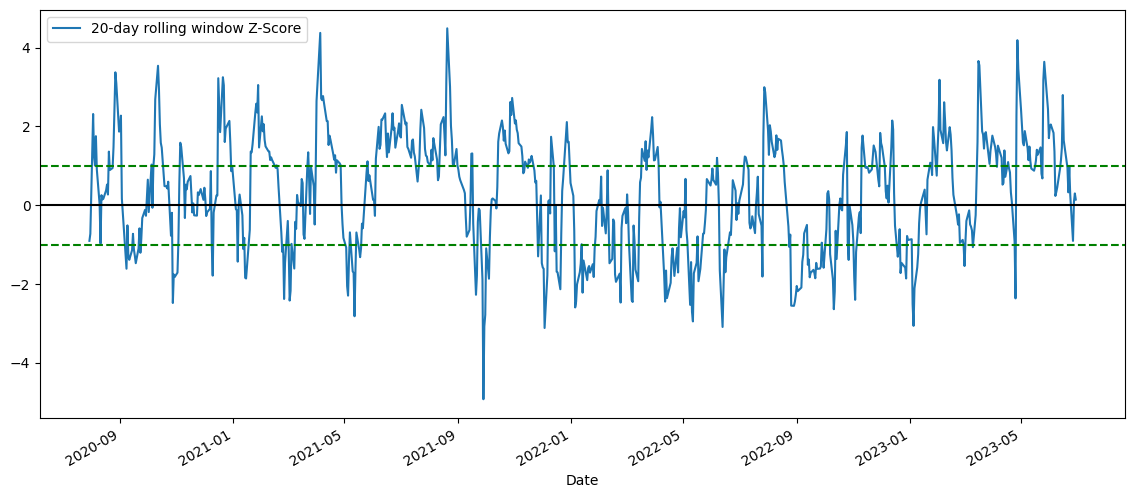

In [47]:
zscore(spread).plot(figsize=(14, 6))
plt.axhline(0.0, color='black')
plt.axhline(1.0, color='green', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['20-day rolling window Z-Score'])

In [71]:
def generate_trade_signals(S1, S2, spread):
  signals = pd.DataFrame()
  signals['price1'] = S1
  signals['price2'] = S2
  signals['spread'] = spread
  signals['zscore'] = zscore(spread)

  signals.dropna(inplace = True)

  signals['signal1'] = np.select([signals['zscore'] > 1, signals['zscore'] < -1], [1, -1], default = 0)
  signals['position1'] = signals['signal1'].diff()
  signals['signal2'] = -signals['signal1']
  signals['position2'] = signals['signal2'].diff()

  return signals

In [49]:
trade_signals = generate_trade_signals(S1, S2, spread)
trade_signals.dropna(inplace = True)
trade_signals


,price1,price2,spread,zscore,signal1,position1,signal2,position2
Date,,,,,,,,
2020-07-31,158.233994,199.049927,184.102187,-0.725958,0,0.0,0,0.0
2020-08-03,155.594498,210.244736,195.546339,2.315111,1,1.0,-1,-1.0
2020-08-04,156.941498,207.089172,192.263530,1.245662,1,0.0,-1,0.0
2020-08-05,160.251495,206.749359,191.611034,1.004399,1,0.0,-1,0.0
2020-08-06,161.250000,210.060257,194.827607,1.751907,1,0.0,-1,0.0
...,...,...,...,...,...,...,...,...
2023-06-23,129.330002,334.312164,322.094871,0.273493,0,0.0,0,0.0
2023-06-26,127.330002,327.905762,315.877400,-0.906487,0,0.0,0,0.0
2023-06-27,129.179993,333.863159,321.660036,0.079525,0,0.0,0,0.0


import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(trade_signals, *['price1'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(trade_signals, *['price2'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(trade_signals, *['spread'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(trade_signals, *['zscore'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(trade_signals, *[[['price1', 'price2'], ['price2', 'spread'], ['spread', 'zscore'], ['zscore', 'signal1']]], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(trade_signals, *['price1'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(trade_signals, *['price2'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(trade_signals, *['spread'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(trade_signals, *['zscore'], **{})
chart

In [50]:
def plot_pair_trades(trade_signals):
  fig = plt.figure(figsize=(14, 6))
  bx = fig.add_subplot(111)
  series = bx.plot(trade_signals['zscore'], c='#4abdac')
  long = bx.plot(trade_signals['zscore'][trade_signals['position1'] == -1], lw = 0, marker = '^', markersize = 8, c = 'g', alpha = 0.9)
  short = bx.plot(trade_signals['zscore'][trade_signals['position1'] == 1], lw = 0, marker = 'v', markersize = 8, c = 'r', alpha = 0.9)
  stock1 = stock_pair[0]
  stock2 = stock_pair[1]
  plt.title(f'{stock2} / {stock1}')
  plt.legend(['Z-Score', 'Long', 'Short'])

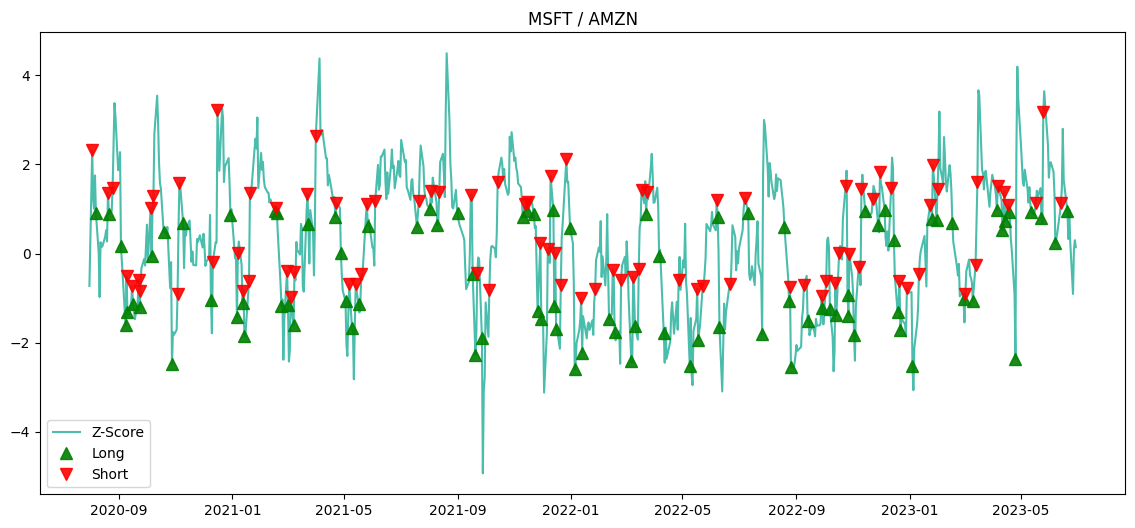

In [51]:
plot_pair_trades(trade_signals)

In [52]:
def plot_trades_1(signals):
  fig = plt.figure(figsize=(14,6))
  bx = fig.add_subplot(111)
  l1 = bx.plot(signals['price1'], c='#4abdac')
  u1 = bx.plot(signals['price1'][signals['position1'] == 1], lw=0, marker='^', markersize=7, c='g',alpha=0.9)
  u2, = bx.plot(signals['price1'][signals['position1'] == -1], lw=0, marker='v', markersize=7, c='r',alpha=0.9)
  plt.title(stock_pair[0])
  plt.legend(['Price', 'Long', 'Short'])

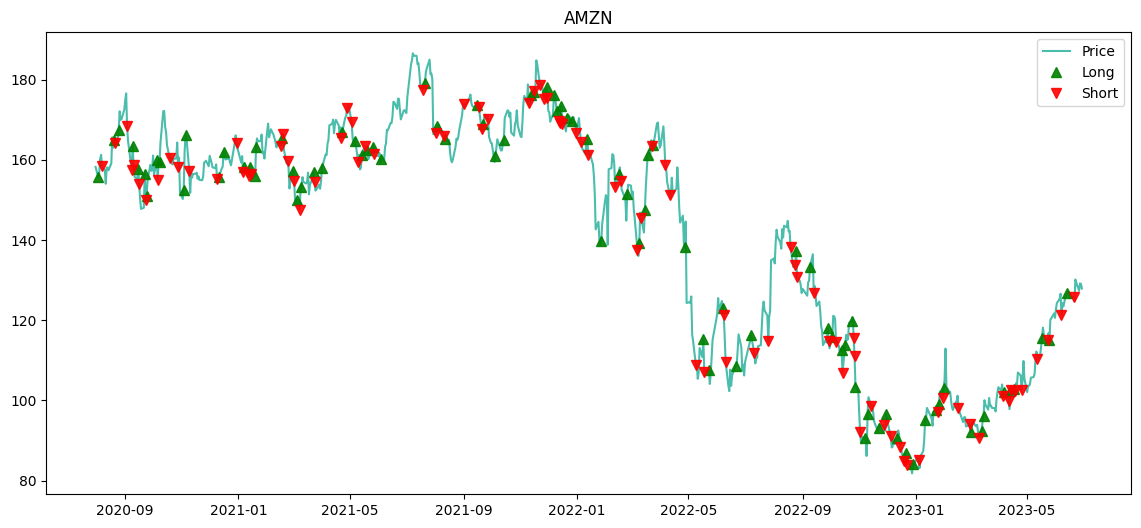

In [53]:
plot_trades_1(trade_signals)

In [54]:
def plot_trades_2(signals):
  fig=plt.figure(figsize=(14,6))
  bx = fig.add_subplot(111)
  l1 = bx.plot(signals['price2'], c='#4abdac')
  u1 = bx.plot(signals['price2'][signals['position2'] == 1], lw=0, marker='^', markersize=7, c='g',alpha=0.9)
  u2 = bx.plot(signals['price2'][signals['position2'] == -1], lw=0, marker='v', markersize=7, c='r',alpha=0.9)
  plt.title(stock_pair[1])
  plt.legend(['Price', 'Long', 'Short'])

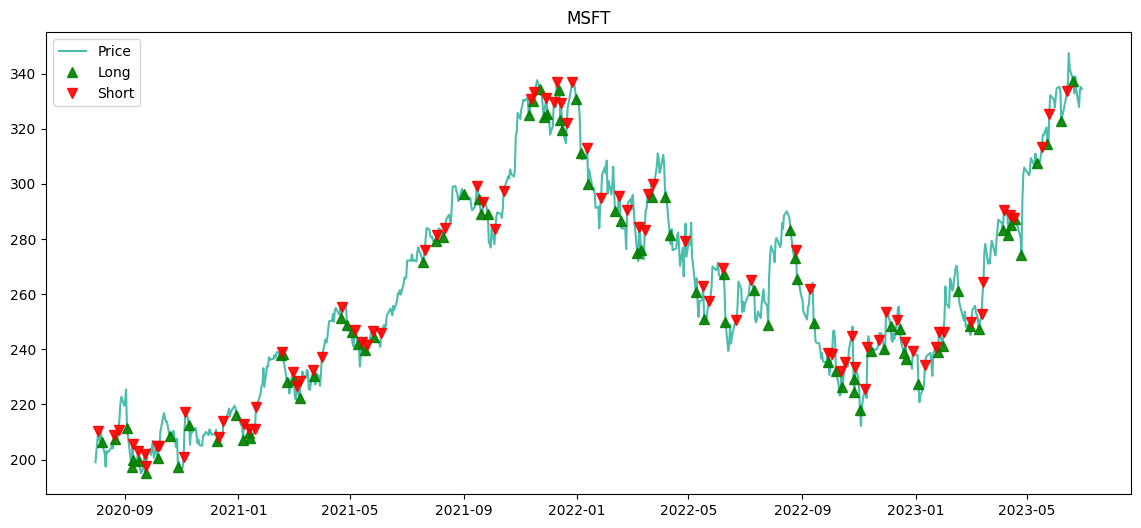

In [55]:
plot_trades_2(trade_signals)

In [56]:
def pnl_calculation(signals):

  initial_capital = 50000

  # Shares to buy for each stock
  shares1 = initial_capital// (signals['price1'][0])
  shares2 = initial_capital// (signals['price2'][0])

  #PnL for stock 1
  portfolio = pd.DataFrame()
  portfolio['holdings1'] = signals['position1'].cumsum() * signals['price1'] * shares1
  portfolio['cash1'] = initial_capital - (signals['position1'] * signals['price1'] * shares1).cumsum()
  portfolio['total1'] = portfolio['holdings1'] + portfolio['cash1']
  portfolio['return1'] = portfolio['total1'].pct_change()

  # PnL for stock 2
  portfolio['holdings2'] = signals['position2'].cumsum() * signals['price2'] * shares2
  portfolio['cash2'] = initial_capital - (signals['position2'] * signals['price2'] * shares2).cumsum()
  portfolio['total2'] = portfolio['holdings2'] + portfolio['cash2']
  portfolio['return2'] = portfolio['total2'].pct_change()

  # Total PnL
  portfolio['total'] = portfolio['total1'] + portfolio['total2']
  portfolio = portfolio.dropna()

  return portfolio


In [57]:
portfolio = pnl_calculation(trade_signals)
portfolio.head()

,holdings1,cash1,total1,return1,holdings2,cash2,total2,return2,total
Date,,,,,,,,,
2020-08-03,49012.266769,987.733231,50000.000000,0.000000,-52771.428665,102771.428665,50000.000000,0.000000,100000.000000
2020-08-04,49436.571808,987.733231,50424.305038,0.008486,-51979.382263,102771.428665,50792.046402,0.015841,101216.351440
2020-08-05,50479.221039,987.733231,51466.954269,0.020678,-51894.089142,102771.428665,50877.339523,0.001679,102344.293793
2020-08-06,50793.750000,987.733231,51781.483231,0.006111,-52725.124496,102771.428665,50046.304169,-0.016334,101827.787399
2020-08-07,0.000000,50875.228577,50875.228577,-0.017502,0.000000,50989.438507,50989.438507,0.018845,101864.667084


In [58]:
def plot_portfolio_value(portfolio):

  fig = plt.figure(figsize=(14,6),)
  ax = fig.add_subplot(111)
  l1, = ax.plot(portfolio['total'], c='g')
  ax.set_ylabel('Asset Value')
  ax.yaxis.labelpad=15
  ax.set_xlabel('Date')
  ax.xaxis.labelpad=15
  plt.title('Portfolio Performance PnL')
  plt.legend(['Total Portfolio Value'])

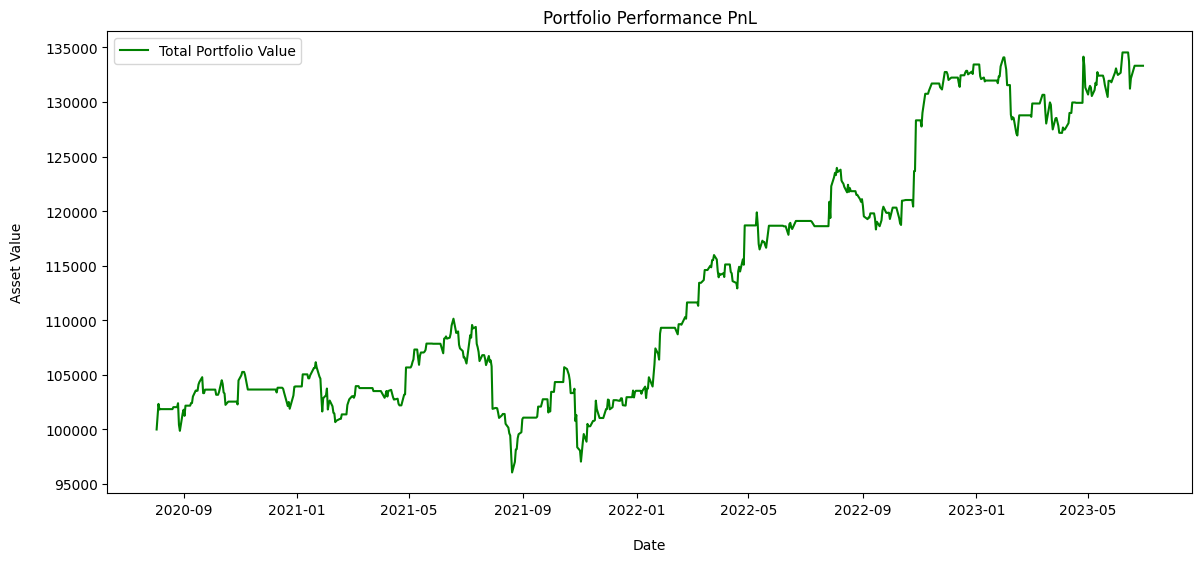

In [59]:
plot_portfolio_value(portfolio)

#**Portfolio Returns**

In [60]:
def calculate_cagr(portfolio):

  final_portfolio = portfolio['total'].iloc[-1]
  initial_portfolio = portfolio['total'].iloc[0]
  delta = len(portfolio.index)
  print('Number of trading days = ', delta)
  YEAR_DAYS = 252
  returns = (final_portfolio/initial_portfolio) ** (YEAR_DAYS/delta) - 1
  return returns

In [61]:
print('CAGR = {:.3f}%' .format(calculate_cagr(portfolio) * 100))

Number of trading days =  732
CAGR = 10.405%


[*********************100%%**********************]  1 of 1 completed


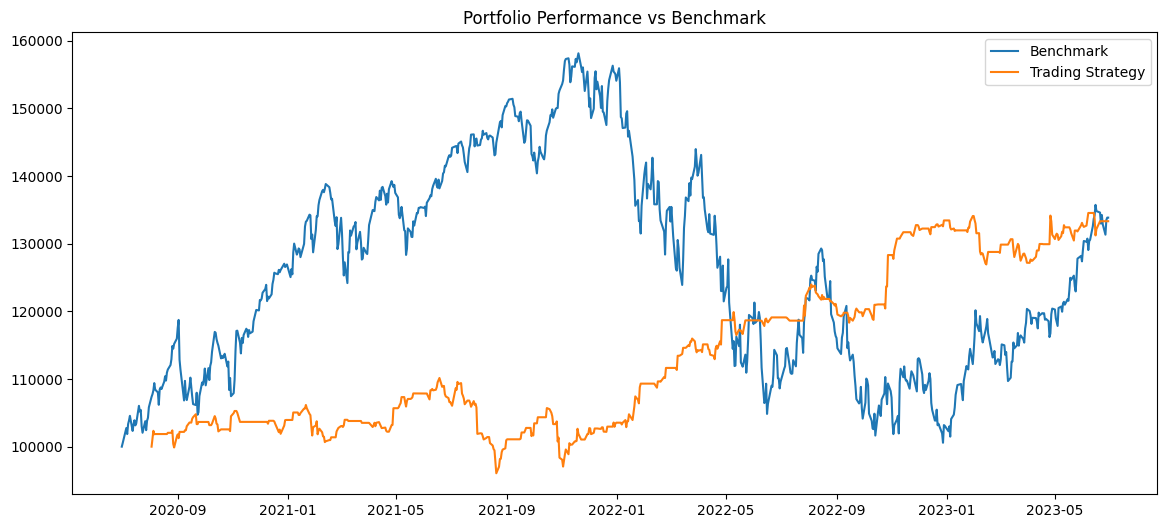

In [62]:
index = yf.download('^IXIC', start = '2020-07-01', end = '2023-06-30')['Adj Close']
shares = 100000/index[0]

plt.figure(figsize = (14, 6))
plt.plot(index*shares)
plt.plot(portfolio['total'])
plt.title('Portfolio Performance vs Benchmark')
plt.legend(['Benchmark', 'Trading Strategy'])

In [63]:
cagr_index = (index.iloc[-1] / index[0])**(252/len(index)) - 1
print("CAGR of NASDAQ:", np.round(cagr_index*100, 3), "%")
cagr_portfolio = (portfolio['total'][-1] / portfolio['total'][0]) ** (252/len(portfolio)) - 1
print("CAGR of trading strategy:", np.round(cagr_portfolio*100, 3), "%")

CAGR of NASDAQ: 10.233 %
CAGR of trading strategy: 10.405 %


In [64]:
import yfinance as yf
import pandas as pd

# Get the stock prices of MSFT and AMZN for the last 3 years
msft = yf.download('MSFT', period='3y')['Adj Close']
amzn = yf.download('AMZN', period='3y')['Adj Close']

# Calculate the cumulative returns
msft_cumulative_return = (msft[-1] - msft[0]) / msft[0]
amzn_cumulative_return = (amzn[-1] - amzn[0]) / amzn[0]

# Print the cumulative returns
print('MSFT cumulative return:', msft_cumulative_return)
print('AMZN cumulative return:', amzn_cumulative_return)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
MSFT cumulative return: 0.5246271984013008
AMZN cumulative return: -0.22829261477172672


In [65]:
def annualized_sharpe_ratio(returns, risk_free_rate):
  """Calculates the annualized Sharpe ratio.

  Args:
    returns: A pandas Series of returns.
    risk_free_rate: The risk-free rate.

  Returns:
    A float representing the annualized Sharpe ratio.
  """

  # Calculate the Sharpe ratio.
  sharpe_ratio = (returns.mean() - risk_free_rate) / returns.std()

  # Annualize the Sharpe ratio.
  annualized_sharpe_ratio = np.sqrt(252) * sharpe_ratio

  # Return the annualized Sharpe ratio.
  return annualized_sharpe_ratio


In [66]:
msft = yf.download('MSFT', period='3y')['Adj Close']
amzn = yf.download('AMZN', period='3y')['Adj Close']
msft_returns = msft.pct_change().dropna()
amzn_returns = amzn.pct_change().dropna()
msft_annualized_sharpe_ratio = annualized_sharpe_ratio(msft_returns, risk_free_rate=0.03)
amzn_annualized_sharpe_ratio = annualized_sharpe_ratio(amzn_returns, risk_free_rate=0.03)
print('MSFT annualized Sharpe ratio:', msft_annualized_sharpe_ratio)
print('AMZN annualized Sharpe ratio:', amzn_annualized_sharpe_ratio)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
MSFT annualized Sharpe ratio: -26.2121337828767
AMZN annualized Sharpe ratio: -20.227376555348663


In [69]:
# Calculate maximum drawdown for a given time series
def calculate_max_drawdown(series):
    """
    Calculate the maximum drawdown for a given time series.

    Parameters:
    series (pd.Series): Time series data.

    Returns:
    float: Maximum drawdown.
    """
    cum_returns = (1 + series.pct_change()).cumprod()
    peaks = cum_returns.cummax()
    drawdowns = (cum_returns - peaks) / peaks
    max_drawdown = drawdowns.min()
    return max_drawdown

# Calculate maximum drawdown for MSFT and AMZN for the past 3 years
msft_max_drawdown = calculate_max_drawdown(data['MSFT'][-756:])  # 252 trading days per year * 3 years = 756 days
amzn_max_drawdown = calculate_max_drawdown(data['AMZN'][-756:])

# Print the maximum drawdown for each stock
print('Maximum Drawdown for MSFT: {:.2%}'.format(msft_max_drawdown))
print('Maximum Drawdown for AMZN: {:.2%}'.format(amzn_max_drawdown))


Maximum Drawdown for MSFT: -28.04%
Maximum Drawdown for AMZN: -34.10%


NameError: ignored

Trade frequency for Asset 1 (S1) in the last 3 years: 0
Trade frequency for Asset 2 (S2) in the last 3 years: 0
